# Spectral Clustering of Countries Economic Development

## Introduction
This notebook aims to investigate if spectral clustering can be applied for the task of grouping the financial growth of 113 countries over the past 58 years. The whole process is documented step by step.

### Imports

In [1]:
import numpy as np

import Utils.DataUtils as DataUtils
import Utils.VisualUtils as VisualUtils

import Clustering.PreProcessing as PreProcessing
import Clustering.SpectralClustering as SpectralClustering

### Data
For each country, three different time series of data are considered; the annual evolution of its GDP per capita, the annual evolution of its population and the annual evolution of the bilateral exchange rate of its currency against the US Dollar. While there is (partially) available data for the GDP and population evolution all the way from 1900, data about currency exchange rates is only available since 1960. For all three time series, the latest data concerns 2017. In order to stabilize the dataset, all GDP and population data before 1960 is discarded.

Because the GDP time series present very high variance, the logarithm of the series is taken instead to smoothen the results.

The data for each time series is loaded from a `.csv` file to create a $113 \times T$ matrix, where $T$ is the amount of years each time series is available for.

In [2]:
n = 113
T_gdp = 118
T_pop = 118
T_currency = 58
start_year = 1960

names_path = "Data/names.txt"
gdp_path = "Data/yp_raw.csv"
population_path = "Data/pop_raw.csv"
currency_path = "Data/currency.csv"

In [3]:
names, gdp, pop, currency = DataUtils.load_clustering_data(
    names_path, gdp_path, population_path, currency_path, n, T_gdp, T_pop, T_currency
)
gdp_data = np.log(gdp[:, -T_currency:])
pop_data = pop[:, -T_currency:]

## Data Preparation
Before the clustering algorithms are applied, the time series data is concatenated for all countries and then standardized.

One complication that arises for currency exchange rate data when it comes to countries of former Yugoslavia and USSR. For these countries (Serbia, Croatia, Bosnia and Herzegovina and Russia respectively) no data is available until 1990. To tackle this problem, a nearest neighbor imputer is used to fill the empty values.

In [4]:
df, scaled_df = PreProcessing.preprocess(
    names, gdp_data, pop_data, currency, start_year
)

## Spectral Clustering
We examine two different ways of building the similarity graph; a $k$-nearest neighbor graph and an $\epsilon$-neighborhood graph are used.

In order to tune the number of clusters for the algorithm, the 'eigenvalue' heuristic is used. Specifically, we examine the magnitude of the eigenvalues of the Laplacian matrix of the graph $L$, and take K clusters such that the smallest eigenvalues $\lambda_1$, ..., $\lambda_K$ are significantly smaller than the rest. Afterwards, we examine the information captured by the corresponding eigenvectors. We reduce the number of clusters by one for each eigenvector that does not capture any significant information.

### $k$-nearest neighbor graph:

We use $k=\lfloor \sqrt{n} \rfloor$ neighbors, where $n$ is the number of countries, i.e. 113. 

In [5]:
W_knn = SpectralClustering.knn_graph(n, scaled_df)

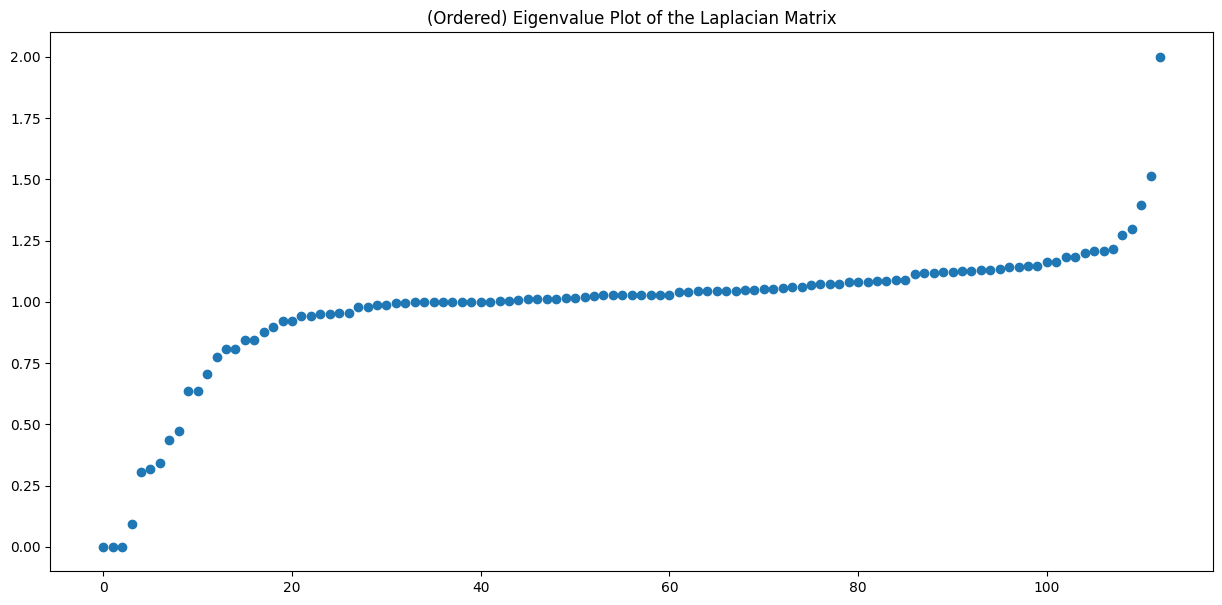

In [6]:
eigvals_knn_norm, eigvecs_knn_norm = SpectralClustering.laplacian_eigen(
    n, W_knn, True, True
)

We conclude 4 clusters are sufficient. We create the H matrix:

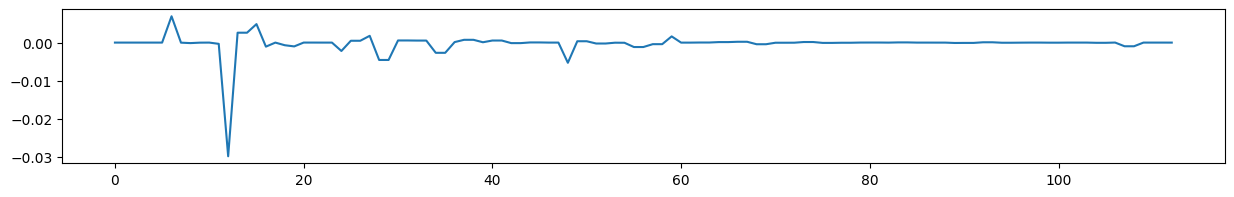

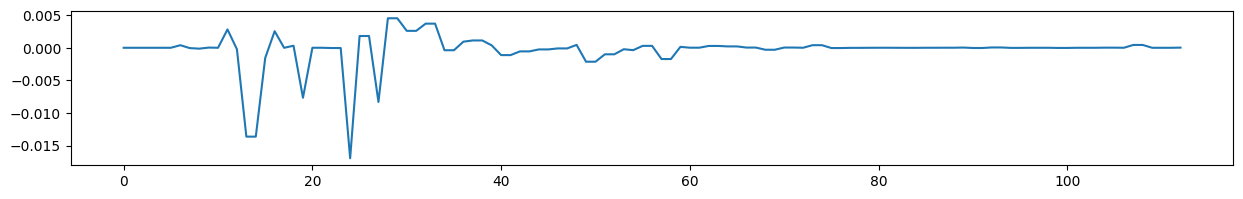

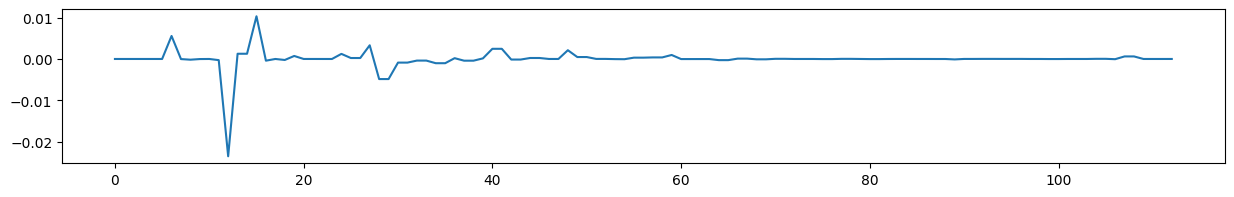

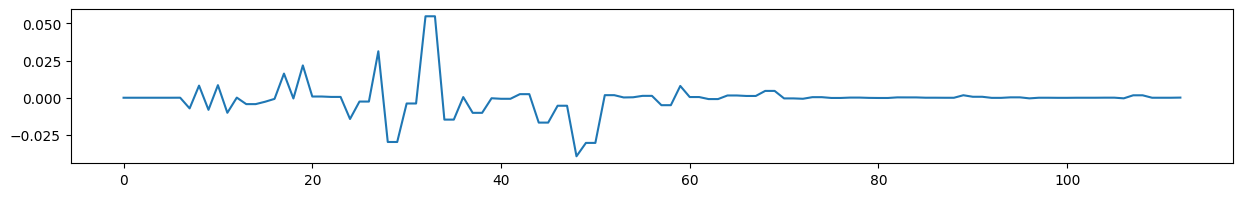

In [7]:
K_knn = 4
H_knn = SpectralClustering.smallest_eigenvecs(
    n, K_knn, eigvals_knn_norm, eigvecs_knn_norm, True
)

All of the eigenvectors are relevant, so now we can perform the clustering with 4 clusters

In [8]:
clusters_knn = SpectralClustering.kmeans(
    H_knn, K_knn, names, True
)

['ARG', 'AUS', 'AUT', 'BDI', 'BEL', 'BEN', 'BFA', 'BGR', 'BOL', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'CRI', 'DEU', 'DOM', 'DZA', 'ETH', 'FIN', 'GRC', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IRN', 'IRQ', 'JPN', 'KEN', 'KHM', 'KOR', 'LAO', 'LBN', 'LBR', 'LKA', 'MAR', 'MDG', 'MEX', 'MLI', 'MMR', 'MNG', 'MOZ', 'MRT', 'MWI', 'MYS', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'PRY', 'PSE', 'ROU', 'RUS', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLE', 'SLV', 'SRB', 'SWE', 'SYR', 'TCD', 'TGO', 'THA', 'TUN', 'TUR', 'TWN', 'TZA', 'UGA', 'URY', 'USA', 'VEN', 'VNM', 'YEM', 'ZAF', 'ZMB', 'ZWE']
['ECU', 'FRA', 'GBR']
['EGY', 'ESP', 'ISR', 'ITA', 'JOR']
['BGD', 'BIH', 'BRA', 'DNK', 'GHA', 'GIN', 'GTM', 'HKG', 'IND', 'IRL']


### $\epsilon$-neighborhood graph:

In order for the similarity graph to be sparse, we set $\epsilon$ to the 10th percentile of the distances.

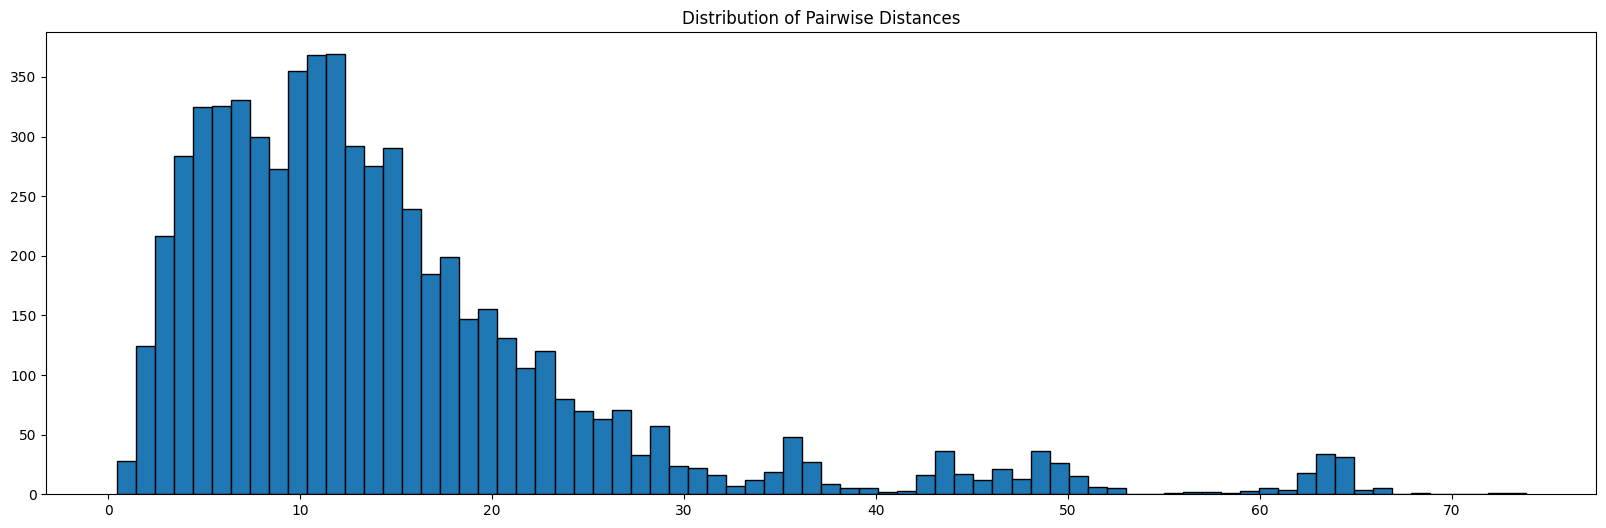

epsilon = 4.337176308344732


In [9]:
W_eps = SpectralClustering.epsilon_graph(
    scaled_df, 10, True
)

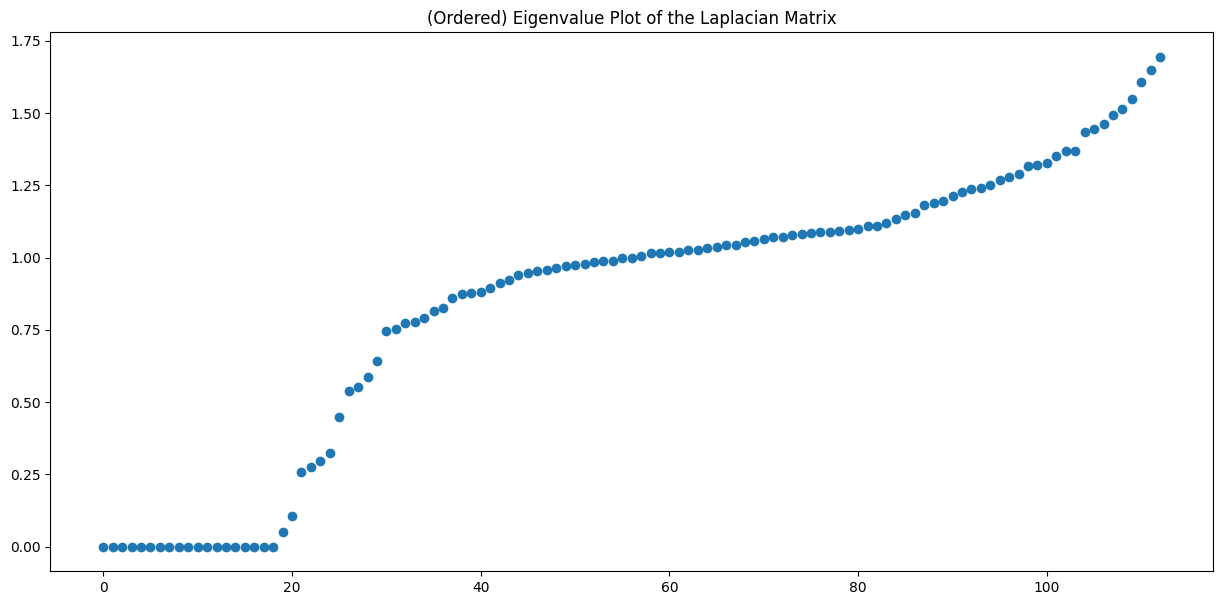

In [10]:
eigvals_eps_norm, eigvecs_eps_norm = SpectralClustering.laplacian_eigen(
    n, W_eps, True, True
)

We conclude 21 clusters are sufficient. We create the H matrix:

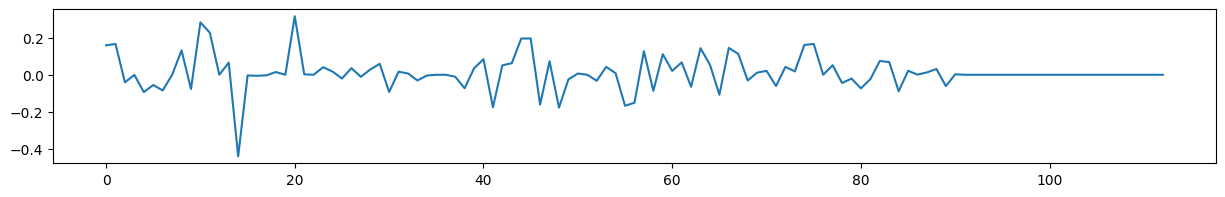

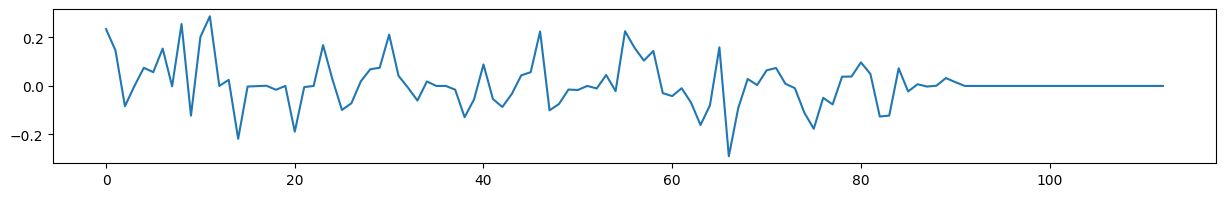

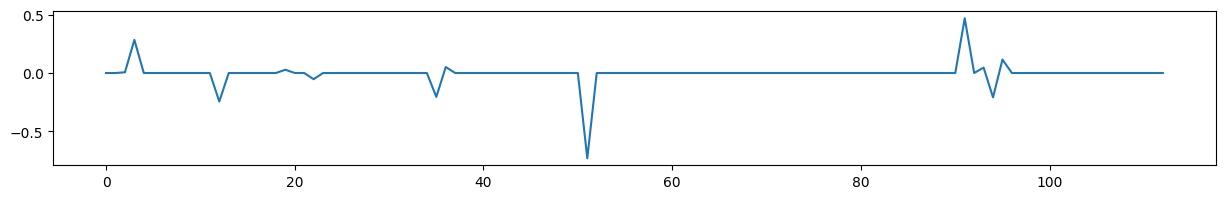

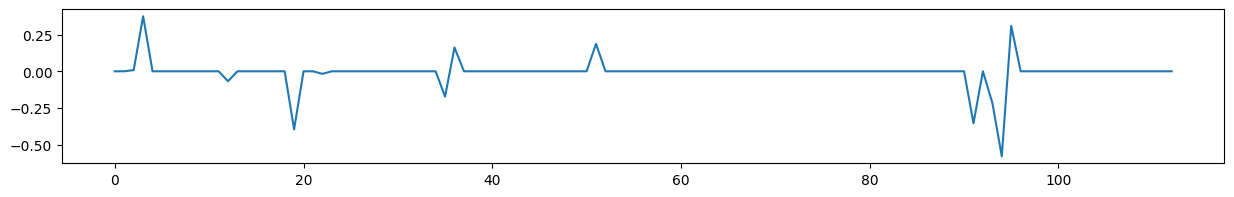

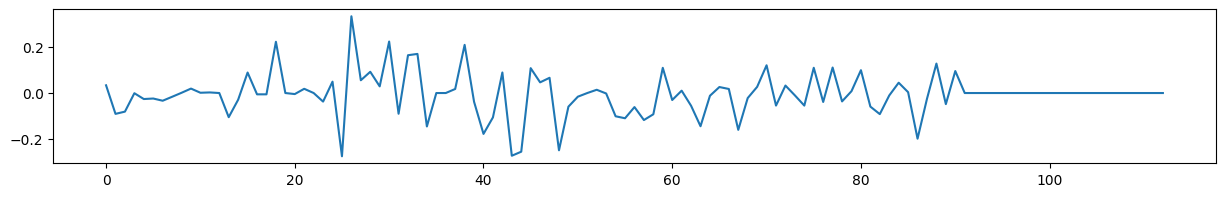

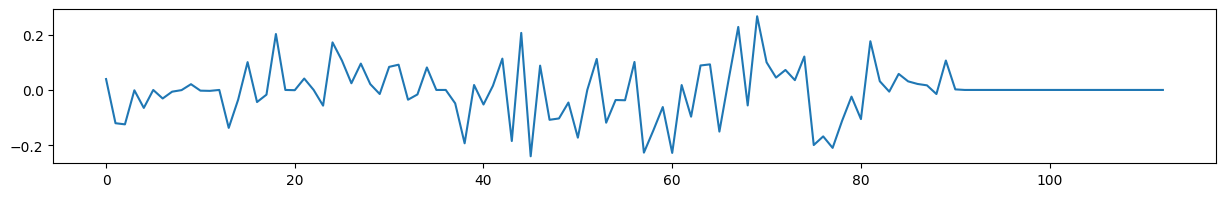

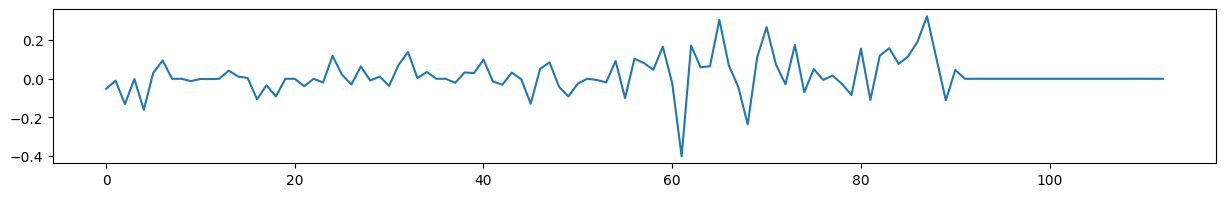

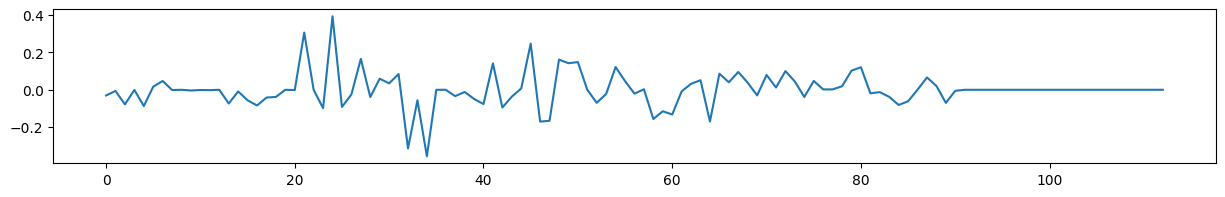

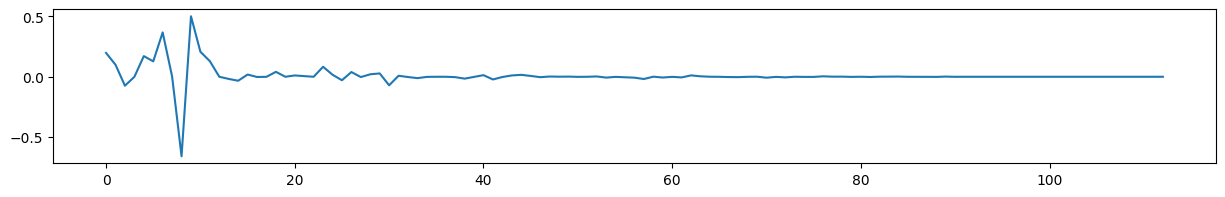

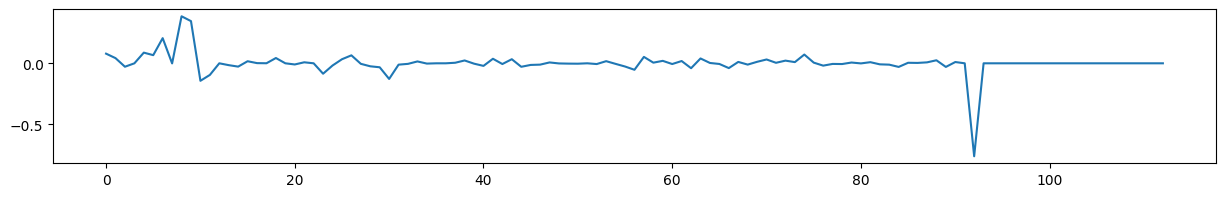

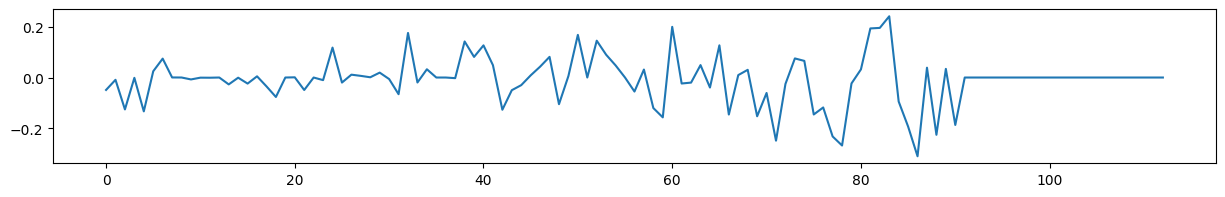

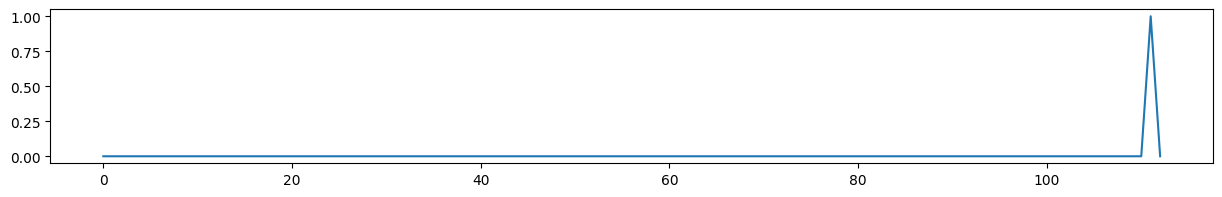

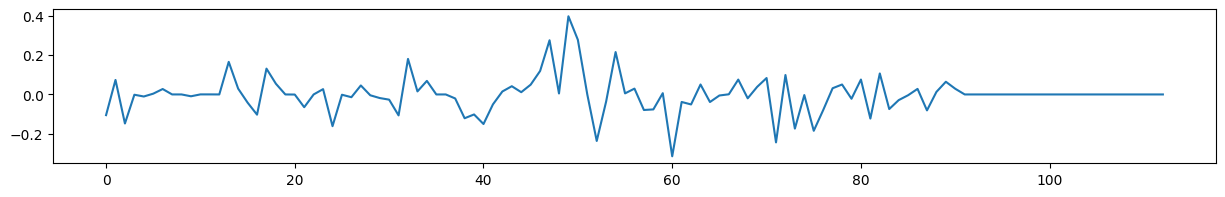

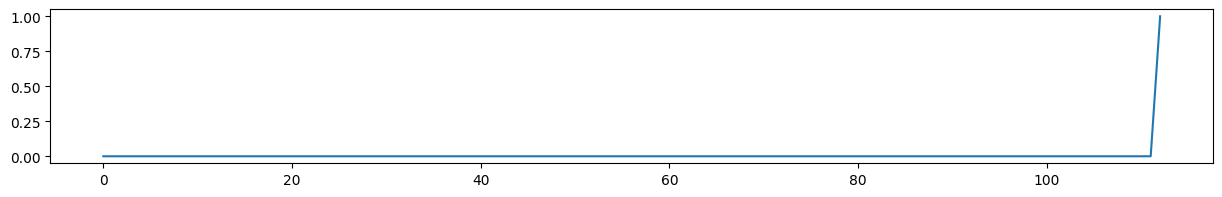

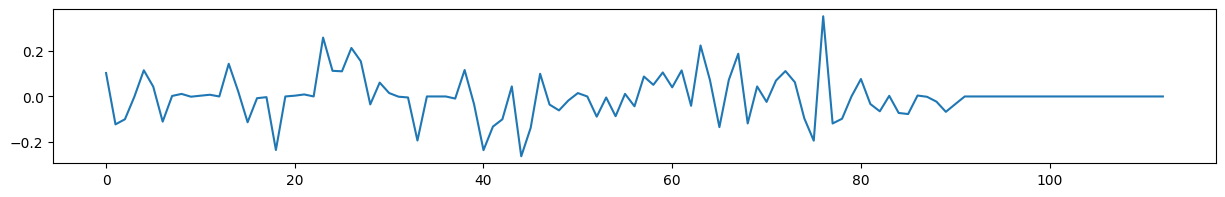

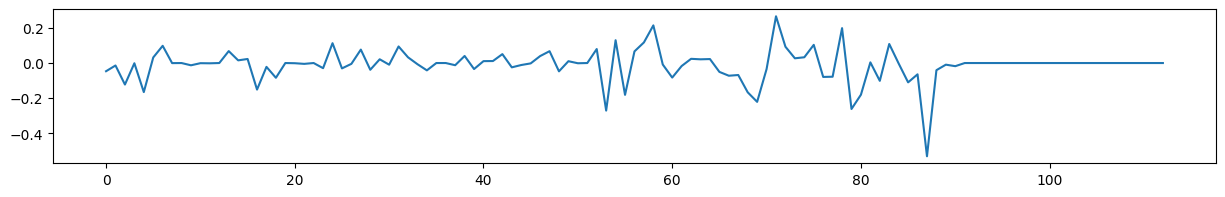

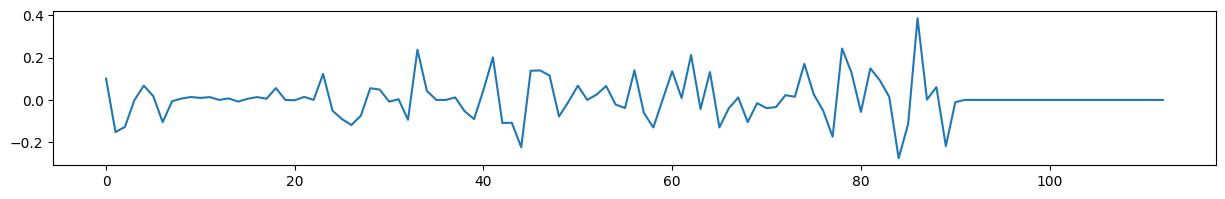

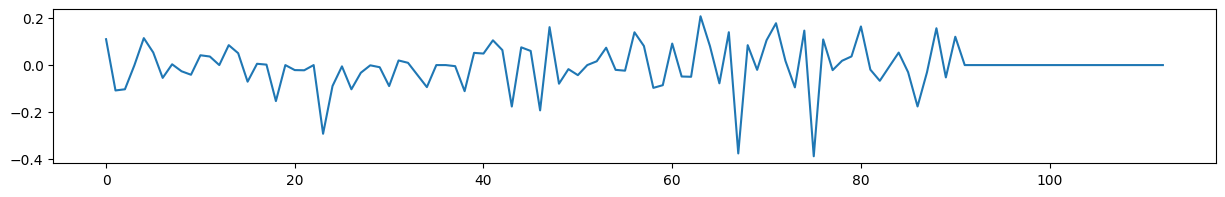

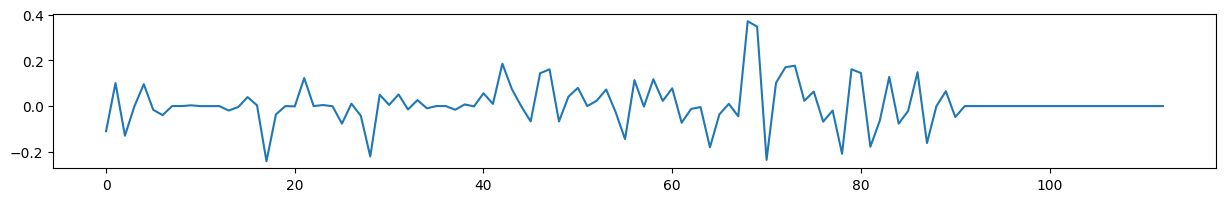

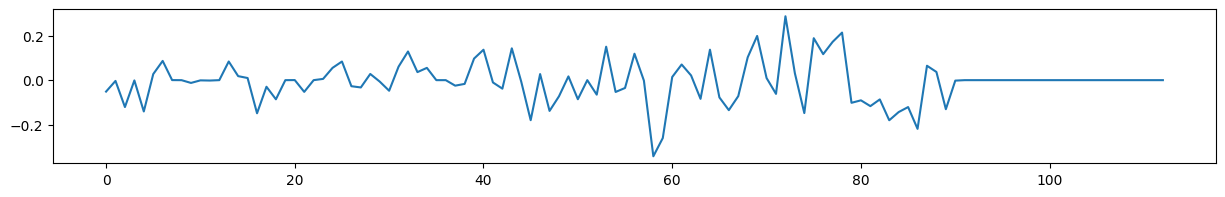

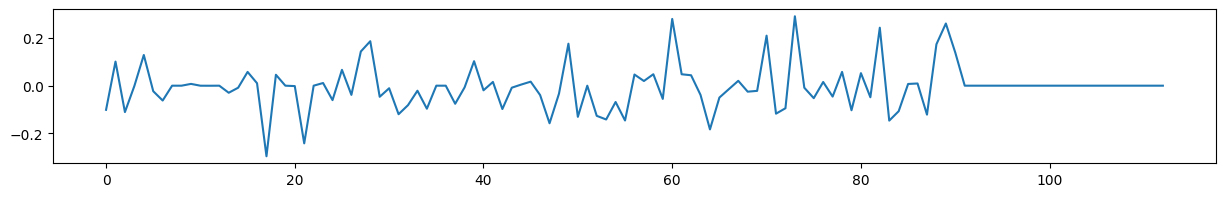

In [11]:
K_eps = 21
H_eps = SpectralClustering.smallest_eigenvecs(
    n, K_eps, eigvals_eps_norm, eigvecs_eps_norm, True
)

Two different eigenvectors give no information, so we can reduce the number of clusters to 19:

In [12]:
clusters_eps = SpectralClustering.kmeans(
    H_eps, K_eps, names, True
)

['FRA', 'GHA']
['COG', 'MMR', 'MRT', 'NPL']
['COL', 'DNK']
['AUT', 'CHE', 'CHN', 'CIV', 'DZA', 'GTM', 'HKG', 'KEN', 'KHM', 'LAO', 'MNG', 'POL', 'PRY']
['BGR']
['BFA', 'BIH']
['ZMB']
['NER']
['JPN']
['ARG', 'BOL', 'BRA', 'ESP', 'ETH', 'IRL', 'PER', 'PHL', 'SLE']
['MDG', 'NOR']
['COD', 'SGP', 'SLV', 'SRB']
['ZWE']
['HUN', 'IND', 'LKA', 'MAR', 'MOZ', 'NGA', 'NIC', 'PSE', 'ROU', 'RUS', 'SAU', 'SEN']
['MWI']
['DEU', 'IRN']
['RWA']
['IRQ']
['CMR', 'GBR', 'NZL', 'PAK', 'PAN']
['ITA', 'JOR', 'KOR']
['AUS', 'BDI', 'BEL', 'BEN', 'BGD', 'CAF', 'CAN', 'CHL', 'CRI', 'DOM', 'ECU', 'EGY', 'FIN', 'GIN', 'GRC', 'HND', 'HRV', 'HTI', 'IDN', 'ISR', 'LBN', 'LBR', 'MEX', 'MLI', 'MYS', 'NLD', 'OMN', 'PRT', 'SDN', 'SWE', 'SYR', 'TCD', 'TGO', 'THA', 'TUN', 'TUR', 'TWN', 'TZA', 'UGA', 'URY', 'USA', 'VEN', 'VNM', 'YEM', 'ZAF']


### $k$-nearest neighbors results
We now visualize the GDP, Population and Currency series for the two smaller clusters proposed by the spectral clustering algorithm that used a $k$-nearest neighbors similarity graph.

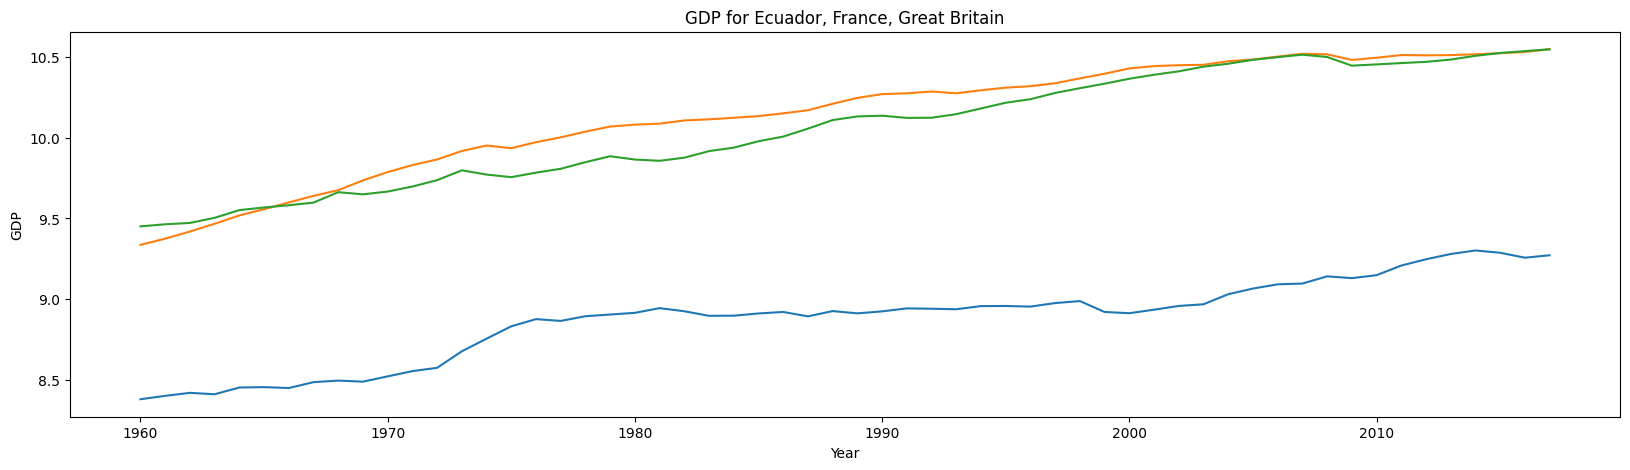

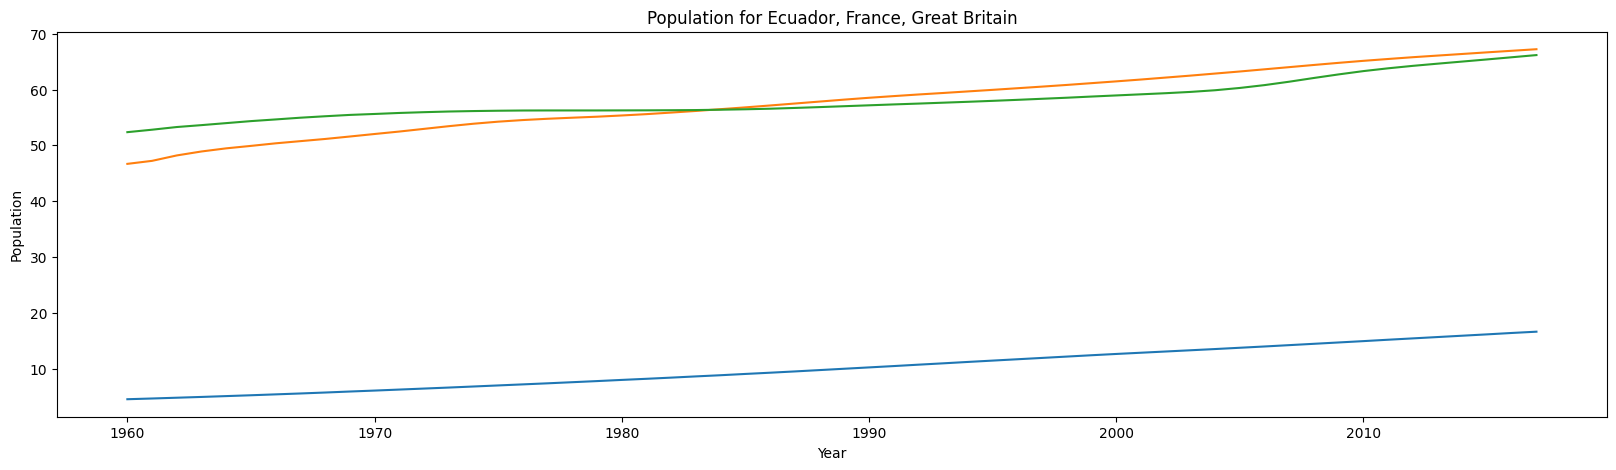

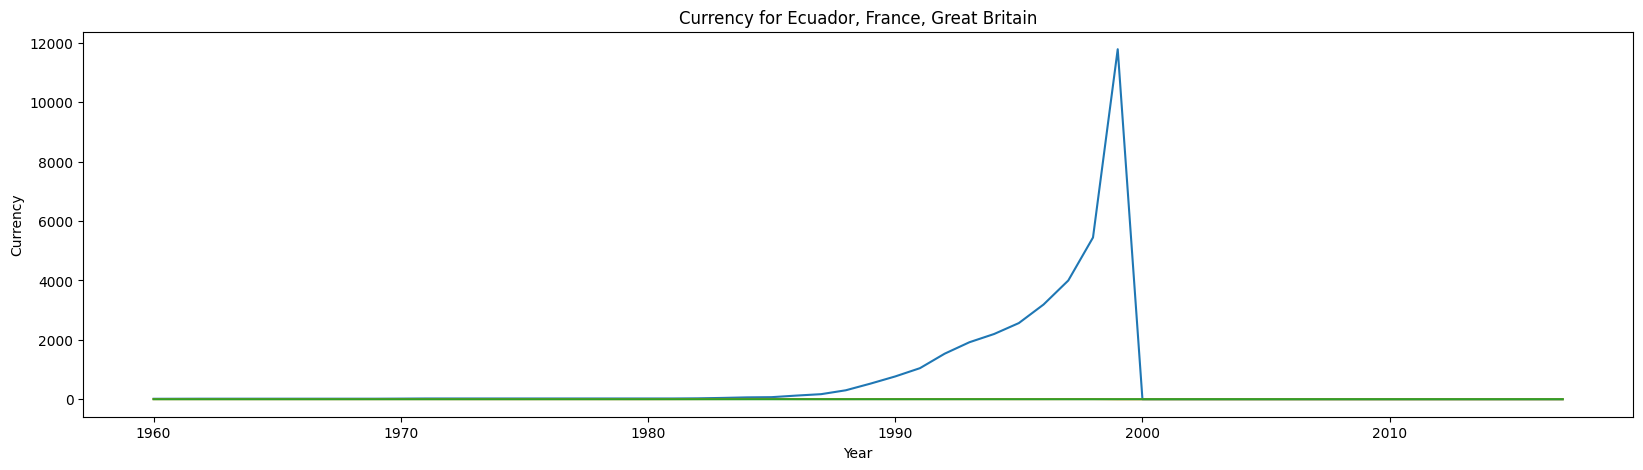

In [13]:
codes1 = ['ECU', 'FRA', 'GBR']
names1 = ['Ecuador', 'France', 'Great Britain']

VisualUtils.show_multiple_countries(
    codes1, names1, df, start_year, T_currency
)

For the first cluster, it is clear that Great Britain and France demonstrate very high similarity in all three time series. On the other hand, while it looks like Ecuador follows similar trends for GDP and population evolution, the magnitude of the values is significantly smaller.

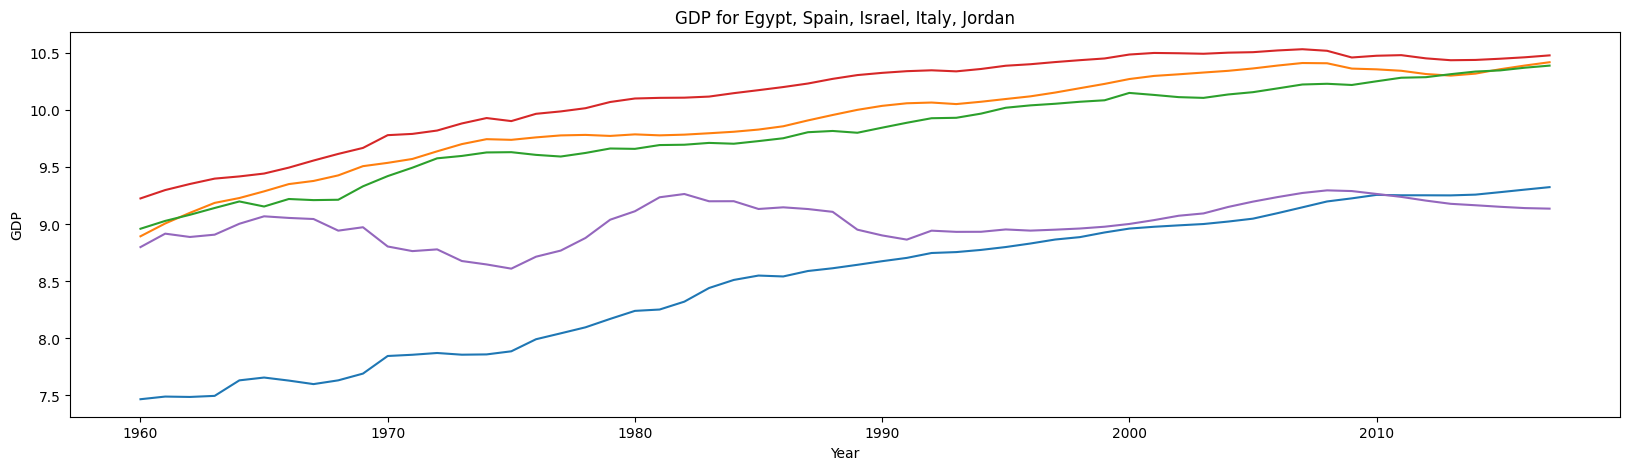

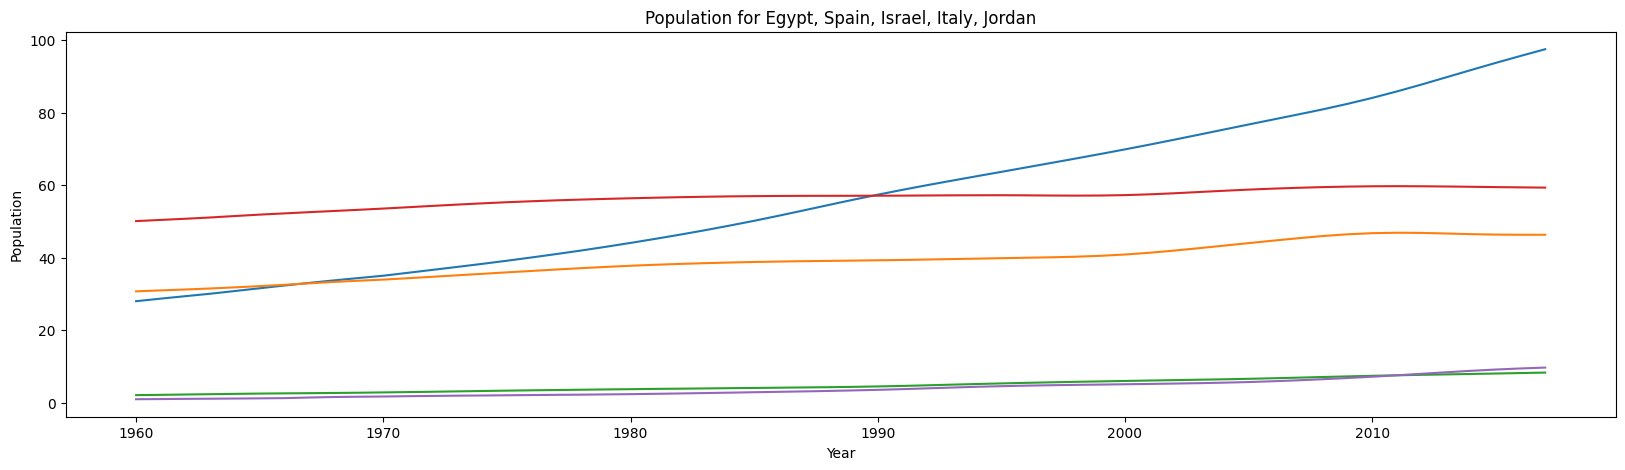

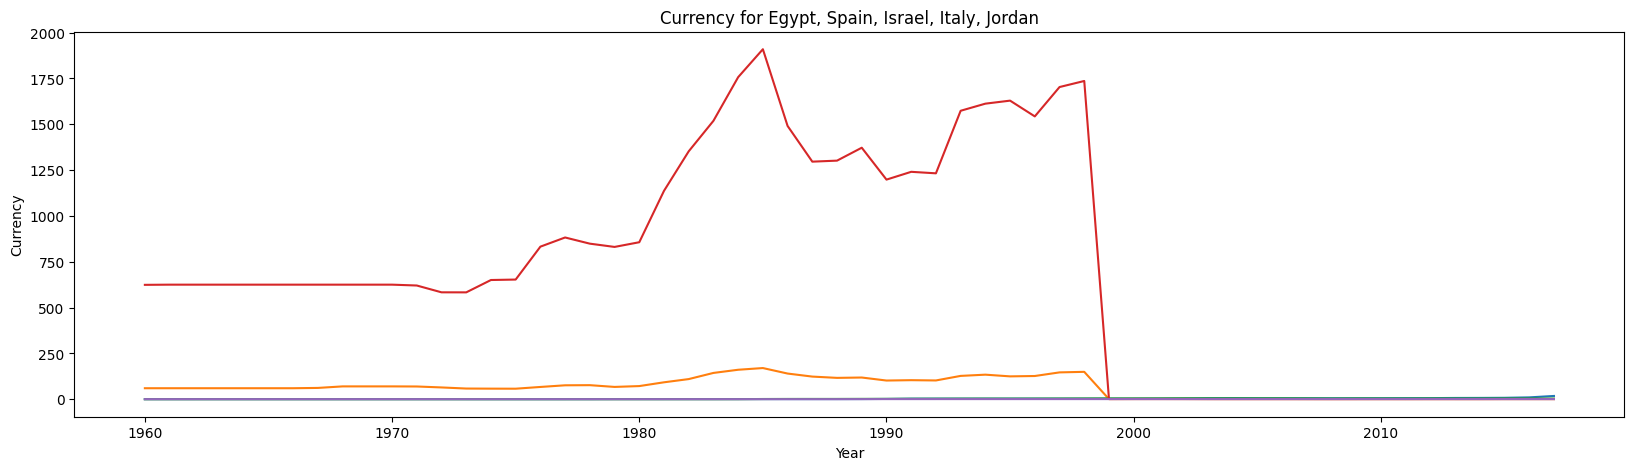

In [14]:
codes2 = ['EGY', 'ESP', 'ISR', 'ITA', 'JOR']
names2 = ['Egypt', 'Spain', 'Israel', 'Italy', 'Jordan']

VisualUtils.show_multiple_countries(
    codes2, names2, df, start_year, T_currency
)

For the second cluster, we notice all 5 countries are countries in the Mediterrenean. However, there are significant differences between the evolutions of all five countries in different time series.

## Conclusion
In general, spectral clustering fails to identify meaniningful clusters. With the exception of the cluster around the Mediterrenean, the clusters have no correlation when it comes to country area and location. Furthermore, both versions of the algorithm have one very dominant cluster, indicating that there are no significant patterns in the data.